# Attrition Model - Exploratory Data Analysis

In [38]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
import mlflow
import warnings

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'

In [11]:
# Add my parent directory to path variables
current_location = Path(os.path.abspath('')).parent.resolve()
print(current_location)
sys.path.append(str(current_location))

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code


In [12]:
raw_data_dir = os.path.join(current_location, "raw_data")
os.makedirs(raw_data_dir, exist_ok=True)

transformed_data_dir = os.path.join(current_location, "transformed_data")
os.makedirs(transformed_data_dir, exist_ok=True)

output_data_dir = os.path.join(current_location, "output_data")
os.makedirs(output_data_dir, exist_ok=True)

In [15]:
attrition_fname = os.path.join(raw_data_dir, "employee_attrition_data_final.xlsx")
employee_attribution_data = pd.read_excel(attrition_fname)

print(employee_attribution_data.columns)
print(employee_attribution_data.shape)
employee_attribution_data.head()

Index(['EmployeeID', 'Age', 'Gender', 'Department', 'Education',
       'MaritalStatus', 'YearsAtCompany', 'JobRole', 'MonthlyIncome',
       'OverTime', 'BusinessTravel', 'DistanceFromHome', 'JobLevel',
       'PercentSalaryHike', 'PerformanceRating', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobSatisfaction',
       'Attrition'],
      dtype='object')
(5000, 20)


,EmployeeID,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
0,1,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,9,4,24,2,2.0,1.0,0,1,No
1,2,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,39,1,20,1,14.0,11.0,7,1,No
2,3,32.0,Male,HR,PhD,Single,35.0,Clerk,7357,No,Non-Travel,1,1,12,1,11.0,7.0,0,4,Yes
3,4,60.0,Male,Support,PhD,Single,39.0,Technician,2327,Yes,Travel_Rarely,33,1,0,2,12.0,6.0,5,"""3.00""",Yes
4,5,25.0,Male,Support,High School,Single,14.0,Executive,12285,Yes,Travel_Rarely,38,5,24,3,9.0,4.0,9,3,Yes


In [142]:
if employee_attribution_data["EmployeeID"].is_unique:
    employee_attribution_data = employee_attribution_data.drop(columns=["EmployeeID"])
    
employee_attribution_data.head(2)

,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
0,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,9,4,24,2,2.0,1.0,0,1,No
1,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,39,1,20,1,14.0,11.0,7,1,No


In [143]:
employee_attribution_data.dtypes.to_dict()

{'Age': dtype('float64'),
 'Gender': dtype('O'),
 'Department': dtype('O'),
 'Education': dtype('O'),
 'MaritalStatus': dtype('O'),
 'YearsAtCompany': dtype('float64'),
 'JobRole': dtype('O'),
 'MonthlyIncome': dtype('int64'),
 'OverTime': dtype('O'),
 'BusinessTravel': dtype('O'),
 'DistanceFromHome': dtype('int64'),
 'JobLevel': dtype('O'),
 'PercentSalaryHike': dtype('int64'),
 'PerformanceRating': dtype('O'),
 'YearsInCurrentRole': dtype('float64'),
 'YearsSinceLastPromotion': dtype('float64'),
 'YearsWithCurrManager': dtype('int64'),
 'JobSatisfaction': dtype('O'),
 'Attrition': dtype('O')}

In [174]:
target_class = "Attrition"
employee_attribution_data[target_class].value_counts()

Attrition
No     3149
Yes    1851
Name: count, dtype: int64

In [175]:
employee_attribution_data.describe()

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,PercentSalaryHike,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,4997.000000,4992.000000,5.000000e+03,5000.000000,5000.000000,4998.000000,4997.000000,5000.000000
mean,41.243346,35.735777,1.157740e+04,24.990600,21.964600,20.757303,12.303582,11.911800
std,13.676054,399.376981,2.607094e+04,14.089436,315.774936,286.886692,202.894029,198.255181
min,4.000000,0.000000,2.000000e+03,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,10.000000,6.642000e+03,13.000000,6.000000,2.250000,1.000000,1.000000
50%,41.000000,20.000000,1.115200e+04,25.000000,12.000000,7.000000,3.000000,3.000000
75%,53.000000,30.000000,1.557850e+04,37.000000,18.000000,15.000000,7.000000,7.000000
max,99.000000,9999.000000,1.532624e+06,49.000000,9999.000000,9590.000000,7359.000000,7444.000000


## Notes:
- looks like w have some anomalies in the max values column for sure

## Remove NaN Values

In [357]:
employee_attribution_data.shape

(5000, 19)

In [176]:
nan_columns = employee_attribution_data.columns[employee_attribution_data.isna().any()].tolist()
print("nan_columns", nan_columns)

employee_attribution_data.isnull().sum()  # Check for missing values

nan_columns ['Age', 'YearsAtCompany', 'PerformanceRating', 'YearsInCurrentRole', 'YearsSinceLastPromotion']


Age                        3
Gender                     0
Department                 0
Education                  0
MaritalStatus              0
YearsAtCompany             8
JobRole                    0
MonthlyIncome              0
OverTime                   0
BusinessTravel             0
DistanceFromHome           0
JobLevel                   0
PercentSalaryHike          0
PerformanceRating          2
YearsInCurrentRole         2
YearsSinceLastPromotion    3
YearsWithCurrManager       0
JobSatisfaction            0
Attrition                  0
dtype: int64

In [374]:
# Drop rows where NaN values are present in any of the identified columns
df_no_nan = employee_attribution_data.dropna(subset=nan_columns)
print(df_no_nan.shape)

df_no_nan.head(2)

(4982, 19)


,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
0,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,9,4,24,2,2.0,1.0,0,1,No
1,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,39,1,20,1,14.0,11.0,7,1,No


In [375]:
object_columns = df_no_nan.select_dtypes(include=['object']).columns.tolist()
object_columns

for col in object_columns:
    print(f"{col}")
    display(df_no_nan[col].value_counts())
    print()

Gender


Gender
Female    2516
Male      2466
Name: count, dtype: int64


Department


Department
Support        1029
Sales          1015
HR              994
Finance         982
Development     962
Name: count, dtype: int64


Education


Education
Masters        1259
PhD            1254
Bachelors      1252
High School    1217
Name: count, dtype: int64


MaritalStatus


MaritalStatus
Married     1677
Divorced    1658
Single      1647
Name: count, dtype: int64


JobRole


JobRole
Clerk         1080
Technician    1007
Manager        990
Engineer       974
Executive      931
Name: count, dtype: int64


OverTime


OverTime
No     2549
Yes    2433
Name: count, dtype: int64


BusinessTravel


BusinessTravel
Travel_Frequently    1720
Non-Travel           1636
Travel_Rarely        1626
Name: count, dtype: int64


JobLevel


JobLevel
1         1024
3          997
2          995
5          994
4          966
"3.00"       4
"4.00"       2
Name: count, dtype: int64


PerformanceRating


PerformanceRating
1         1277
4         1247
2         1242
3         1209
"4.00"       4
"2.00"       3
Name: count, dtype: int64


JobSatisfaction


JobSatisfaction
3         1262
2         1243
1         1241
4         1227
"2.00"       5
"3.00"       4
Name: count, dtype: int64


Attrition


Attrition
No     3139
Yes    1843
Name: count, dtype: int64

In [376]:
df_no_nan[~df_no_nan["JobSatisfaction"].isin([1,2,3,4,5])]["JobSatisfaction"].values


array(['"3.00"', '"3.00"', '"2.00"', '"2.00"', '"3.00"', '"2.00"',
       '"2.00"', '"3.00"', '"2.00"'], dtype=object)

In [377]:
df_no_nan.dtypes

Age                        float64
Gender                      object
Department                  object
Education                   object
MaritalStatus               object
YearsAtCompany             float64
JobRole                     object
MonthlyIncome                int64
OverTime                    object
BusinessTravel              object
DistanceFromHome             int64
JobLevel                    object
PercentSalaryHike            int64
PerformanceRating           object
YearsInCurrentRole         float64
YearsSinceLastPromotion    float64
YearsWithCurrManager         int64
JobSatisfaction             object
Attrition                   object
dtype: object

In [380]:
def identify_numeric_columns_with_object_type(df):
    """
    Identifies numeric columns (int or float) where any value contains quotes (single or double).
    Returns a list of column names that contain values with quotes in numeric columns.
    """
    columns_with_quotes = []
    
    # Iterate through the dataframe columns
    for column in df.columns:
        # Check if the column's dtype is numeric (int or float)
        if pd.api.types.is_object_dtype(df[column]):
            # Check if any value in the column contains quotes
            if df[column].apply(lambda x: isinstance(x, str) and ('"' in x or "'" in x)).any():
                columns_with_quotes.append(column)
    
    return columns_with_quotes


def correct_numeric_columns_with_object_type(value, lower_bound=1, upper_bound=5):
    """
    Tries to convert the value to an integer between lower_bound and upper_bound.
    If it's a valid float/int as a string, it converts it to an int.
    Otherwise, it keeps the original value.
    """
    try:
        value = value.strip('"')
        value = value.strip("'")
        # Attempt to parse the value to a float, then convert to an int
        value = float(value)
        # Ensure it's within the specified bounds
        if lower_bound <= value <= upper_bound:
            return value
    except (ValueError, TypeError, AttributeError):
        # If conversion fails, return the original value
        return value


columns_w_string_values = identify_numeric_columns_with_object_type(df_no_nan)
print(f"columns_w_string_values: {columns_w_string_values}")

columns_w_string_values: ['JobLevel', 'PerformanceRating', 'JobSatisfaction']


In [386]:
for col_name in columns_w_string_values:    
    df_no_nan.loc[:, col_name] = df_no_nan[col_name].apply(correct_numeric_columns_with_object_type)
    df_no_nan.loc[:, col_name] = pd.to_numeric(df_no_nan[col_name], errors='coerce')

In [387]:
df_no_nan[~df_no_nan["JobSatisfaction"].isin([1,2,3,4,5])]["JobSatisfaction"].values

array([], dtype=float64)

In [388]:
df_no_nan.dtypes

Age                        float64
Gender                      object
Department                  object
Education                   object
MaritalStatus               object
YearsAtCompany             float64
JobRole                     object
MonthlyIncome                int64
OverTime                    object
BusinessTravel              object
DistanceFromHome             int64
JobLevel                   float64
PercentSalaryHike            int64
PerformanceRating          float64
YearsInCurrentRole         float64
YearsSinceLastPromotion    float64
YearsWithCurrManager         int64
JobSatisfaction            float64
Attrition                   object
dtype: object

### Apply Anomaly Detection

In [392]:
df_no_nan.shape

(4982, 19)

In [390]:
# pd.api.types.is_object_dtype(df_cleaned["JobSatisfaction"])

# categorical_columns = [column for column in df_no_nan.columns if pd.api.types.is_object_dtype(df_no_nan[column])]
categorical_columns = df_no_nan.select_dtypes(include=['object']).columns
categorical_columns

Index(['Gender', 'Department', 'Education', 'MaritalStatus', 'JobRole',
       'OverTime', 'BusinessTravel', 'Attrition'],
      dtype='object')

In [391]:
numeric_columns = df_no_nan.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['Age', 'YearsAtCompany', 'MonthlyIncome', 'DistanceFromHome',
       'JobLevel', 'PercentSalaryHike', 'PerformanceRating',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobSatisfaction'],
      dtype='object')

In [398]:

def modified_z_score_anomaly_detection_with_two_plots(df, column, threshold=3.5, plot=False):
    """
    Detect anomalies in a specific column using the Modified Z-score method and plot two histograms.
    The left plot shows all data with upper and lower bounds, and the right plot shows only the data within the bounds.
    
    :param df: DataFrame containing the data.
    :param column: The column to perform the Modified Z-score anomaly detection on.
    :param threshold: Modified Z-score threshold for detecting anomalies. Default is 3.5.
    :return: DataFrame with an additional boolean column indicating anomalies.
    """
    # Calculate the median of the column
    median = df[column].median()

    # Calculate the Median Absolute Deviation (MAD)
    mad = np.median(np.abs(df[column] - median))
    
    # Avoid division by zero
    if mad == 0:
        mad = 1e-10
    
    # Calculate Modified Z-scores
    # df[f'modified_z_score_{column}'] = 0.6745 * (df[column] - median) / mad
    df.loc[:, f'modified_z_score_{column}'] = 0.6745 * (df[column] - median) / mad

    # Add a column to indicate anomalies (True if outside the range)
    # df[f'anomaly_{column}'] = np.abs(df[f'modified_z_score_{column}']) > threshold
    df.loc[:, f'anomaly_{column}'] = np.abs(df[f'modified_z_score_{column}']) > threshold
    
    if plot:
        # Plot the histogram with the upper and lower bounds
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Full data plot (Left plot)
        sns.histplot(df[column], kde=True, ax=axes[0])
        upper_bound = median + threshold * mad / 0.6745
        lower_bound = median - threshold * mad / 0.6745
        axes[0].axvline(upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
        axes[0].axvline(lower_bound, color='b', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
        
        # Count anomalies and display it on the plot
        anomaly_count = df[f'anomaly_{column}'].sum()
        data_mean = df[column].mean()
        std = df[column].std()
        title_t = f"""
            Modified Z-Score Detection: {column}.
            Anomaly Count: {anomaly_count}
            Mean: {data_mean:.2f}
            STD : {std: .2f}
        """
        axes[0].set_title(title_t, fontsize=14)
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frequency')
        axes[0].legend()

        # Plot only the data within bounds (Right plot)
        filtered_data = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        filtered_data_mean = filtered_data[column].mean()
        filtered_std = filtered_data[column].std()
        sns.histplot(filtered_data[column], kde=True, ax=axes[1])
        title = f"""
            {column} Data within Bounds'
            Filtered Mean: {filtered_data_mean:.2f}
            Filtered STD : {filtered_std: .2f}
        """
        axes[1].set_title(title, fontsize=14)
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Frequency')
        
        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()

    return df

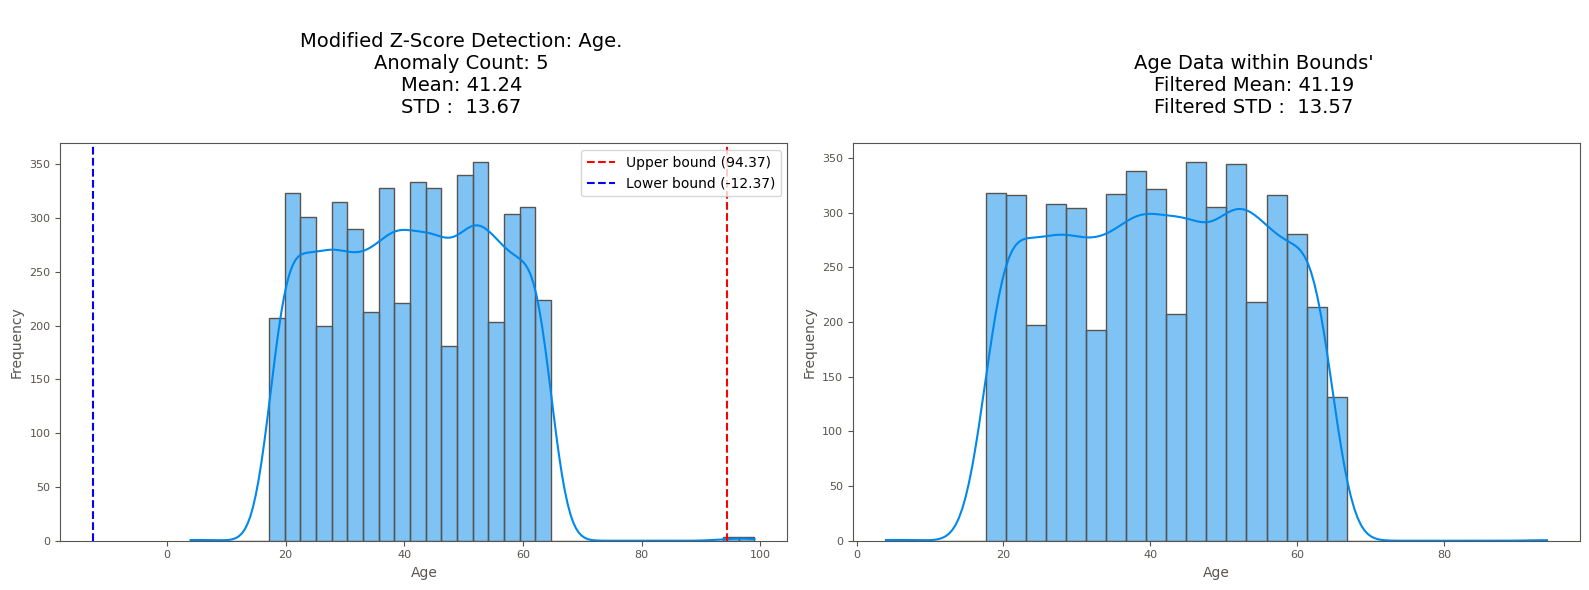

Column: Age



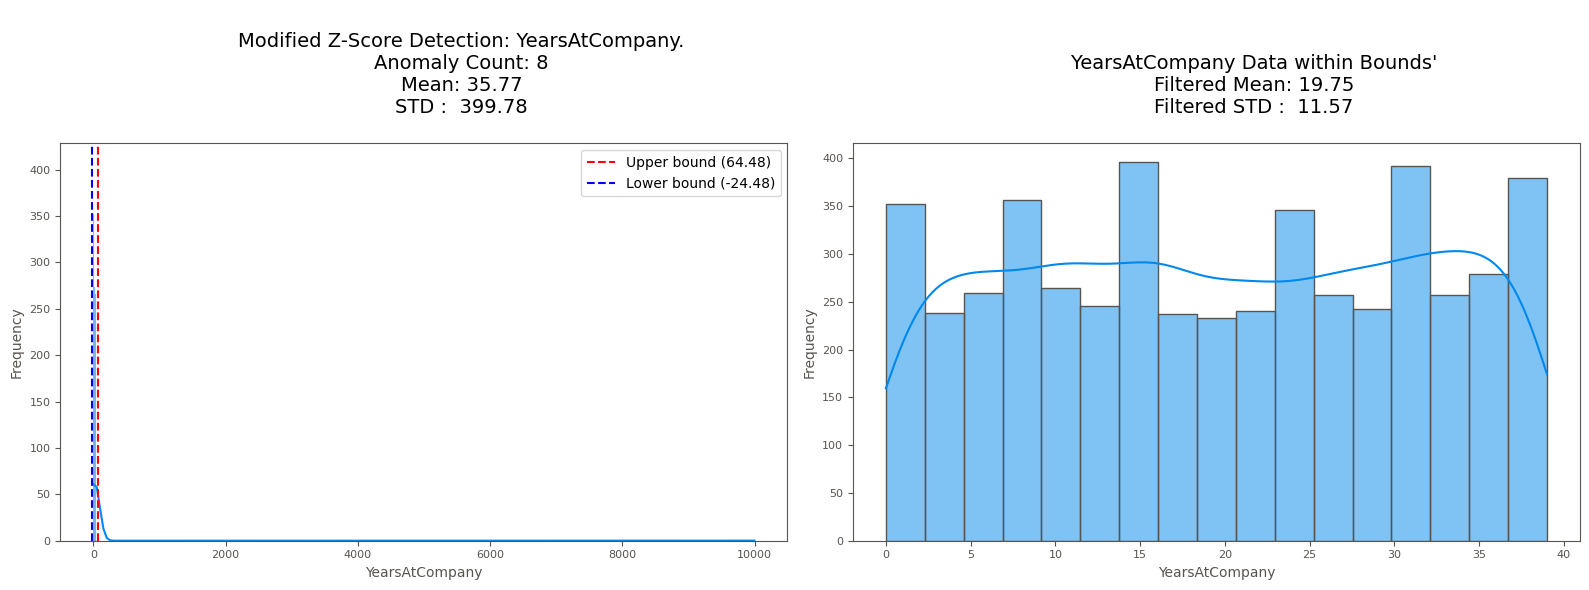

Column: YearsAtCompany



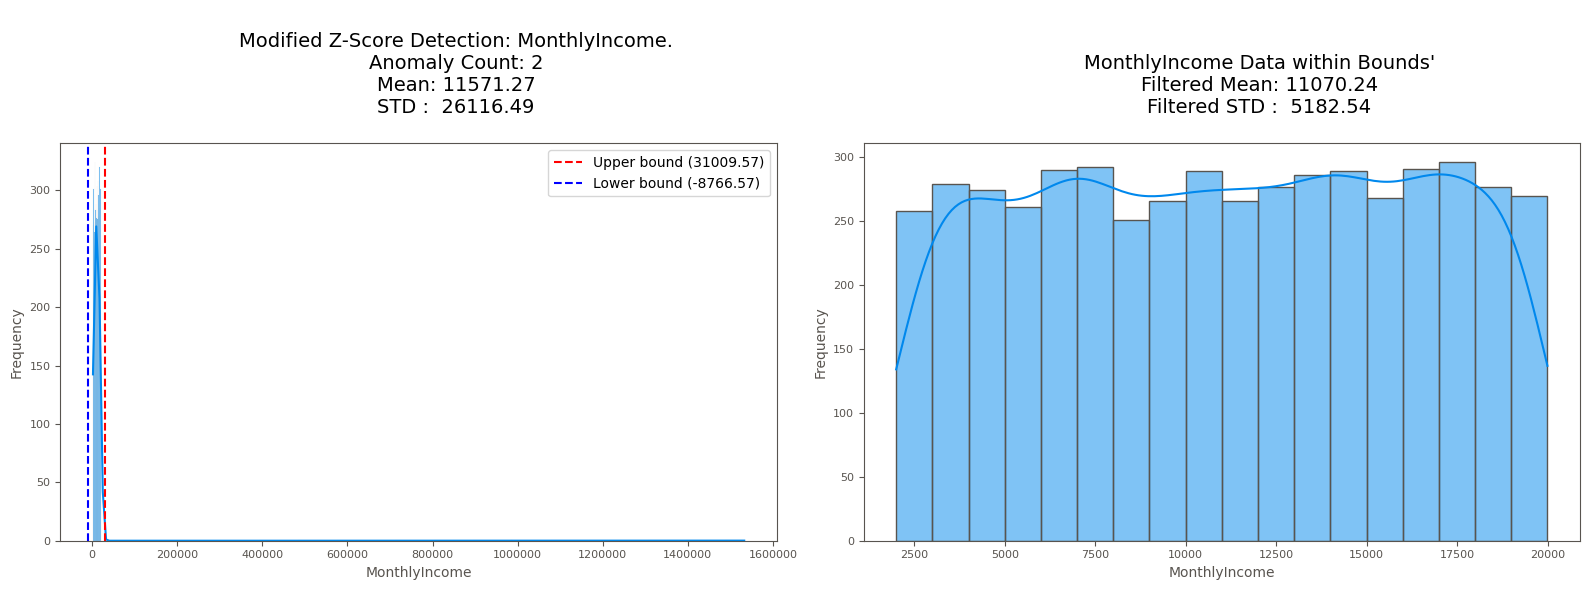

Column: MonthlyIncome



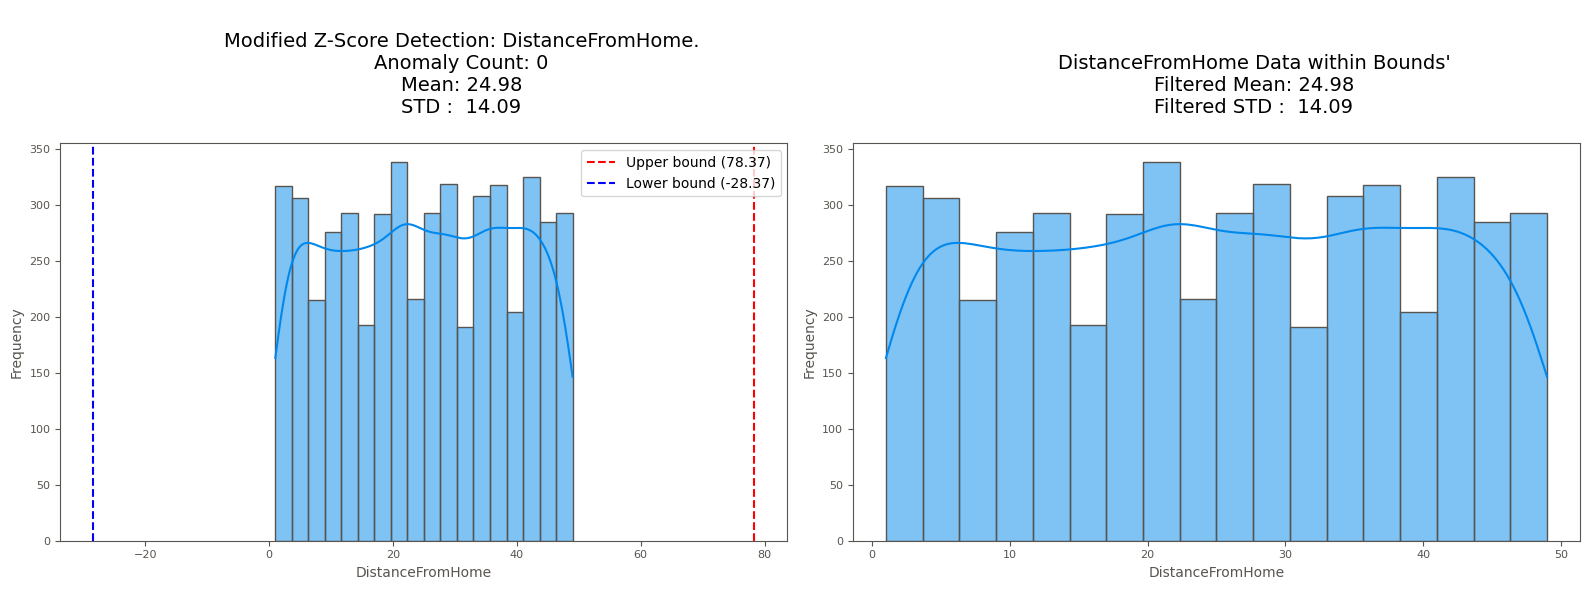

Column: DistanceFromHome



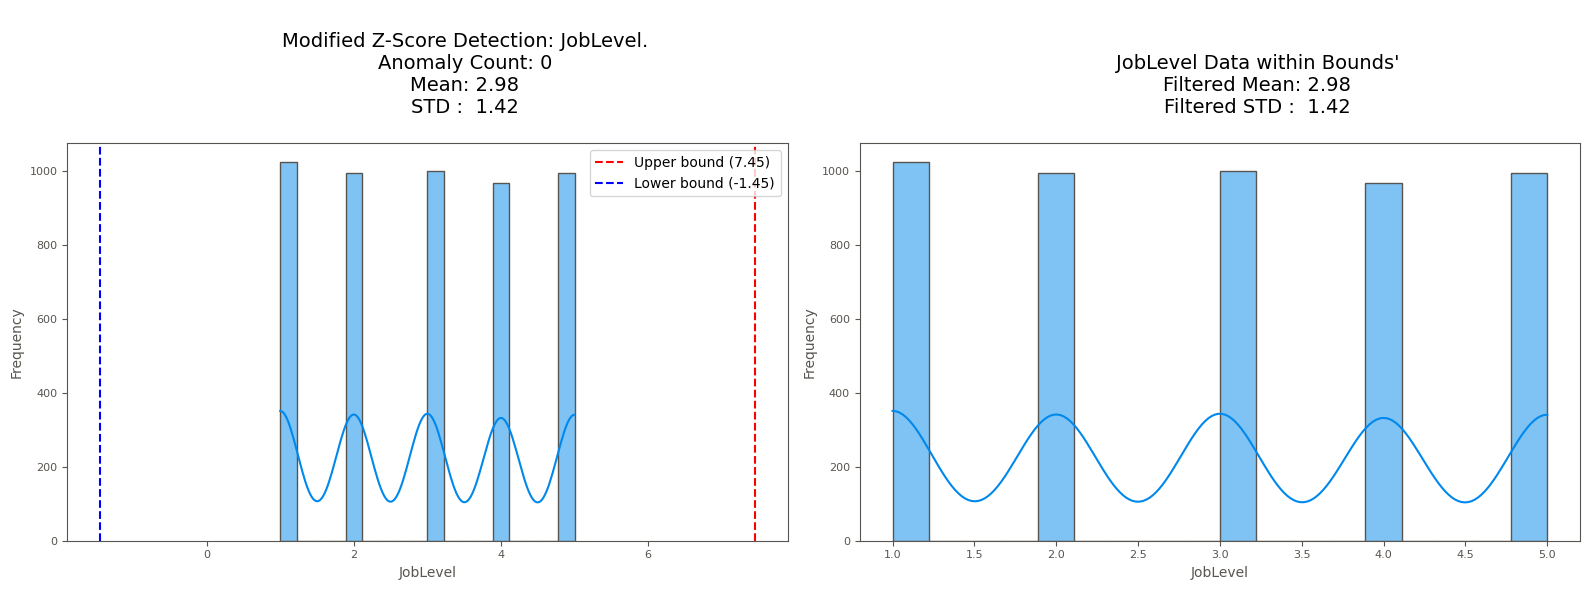

Column: JobLevel



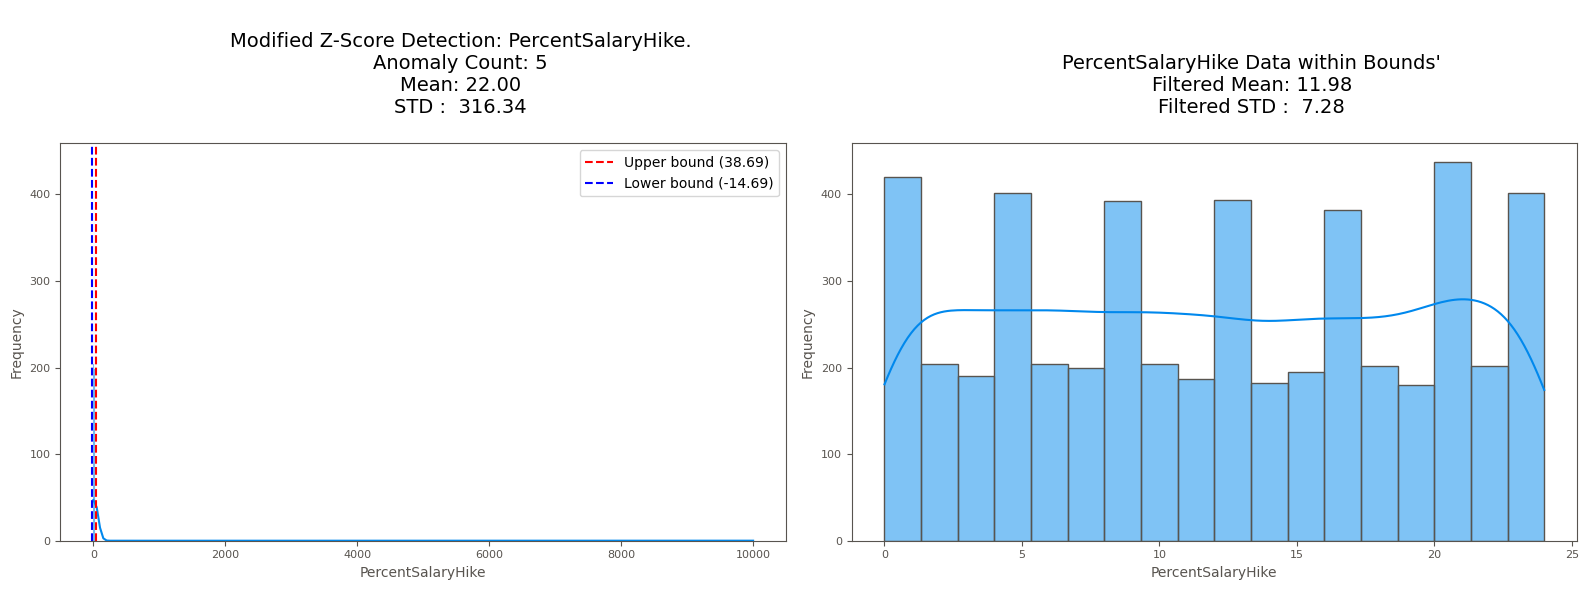

Column: PercentSalaryHike



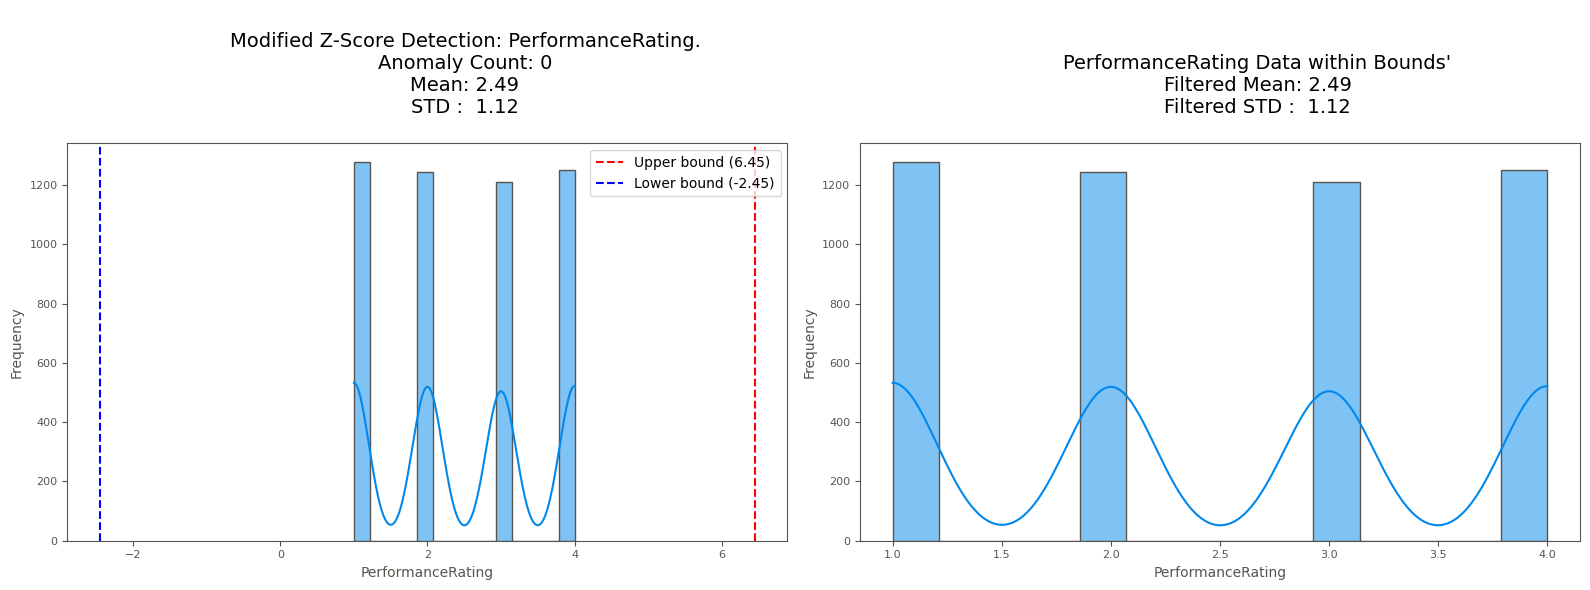

Column: PerformanceRating



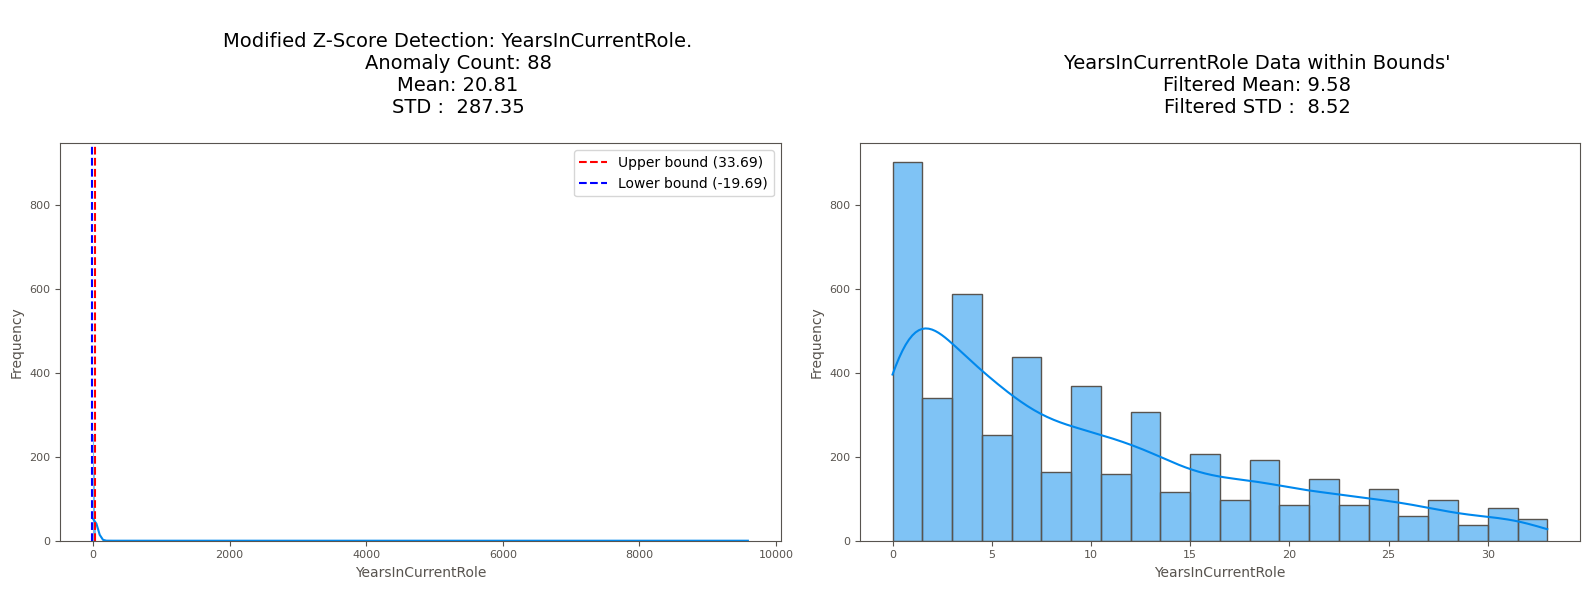

Column: YearsInCurrentRole



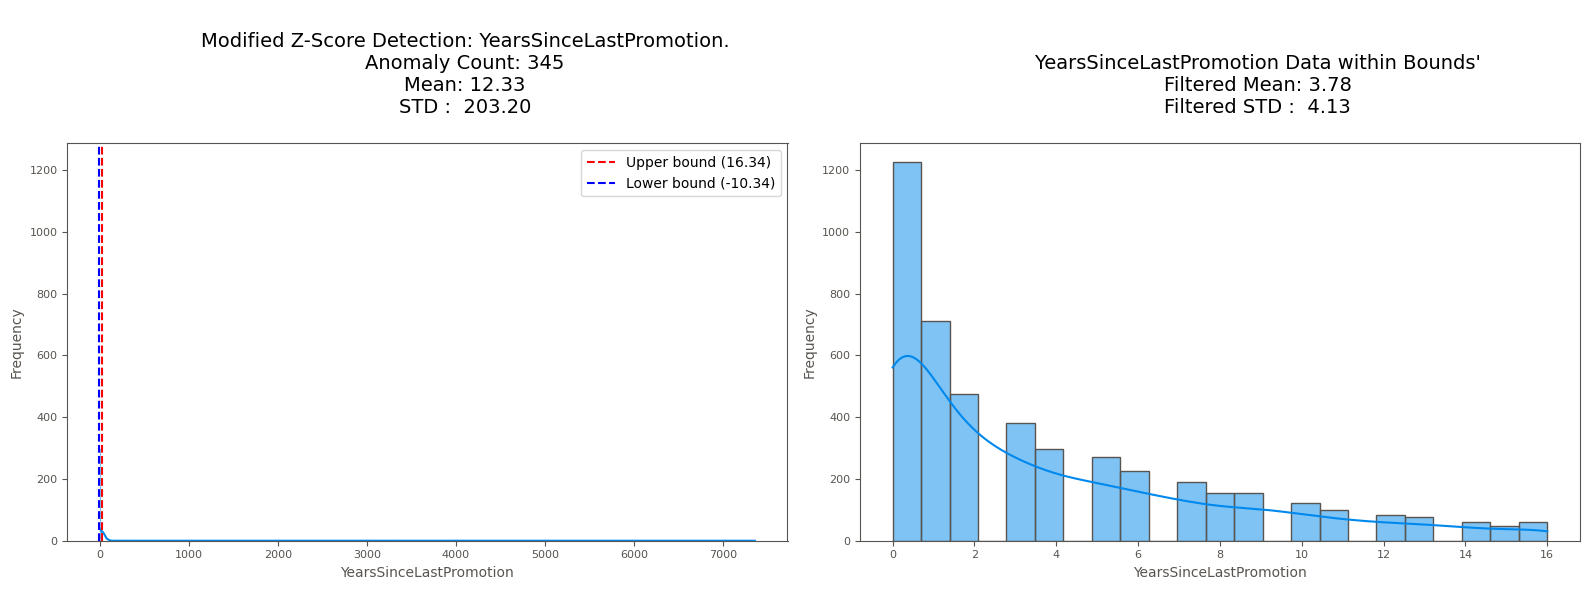

Column: YearsSinceLastPromotion



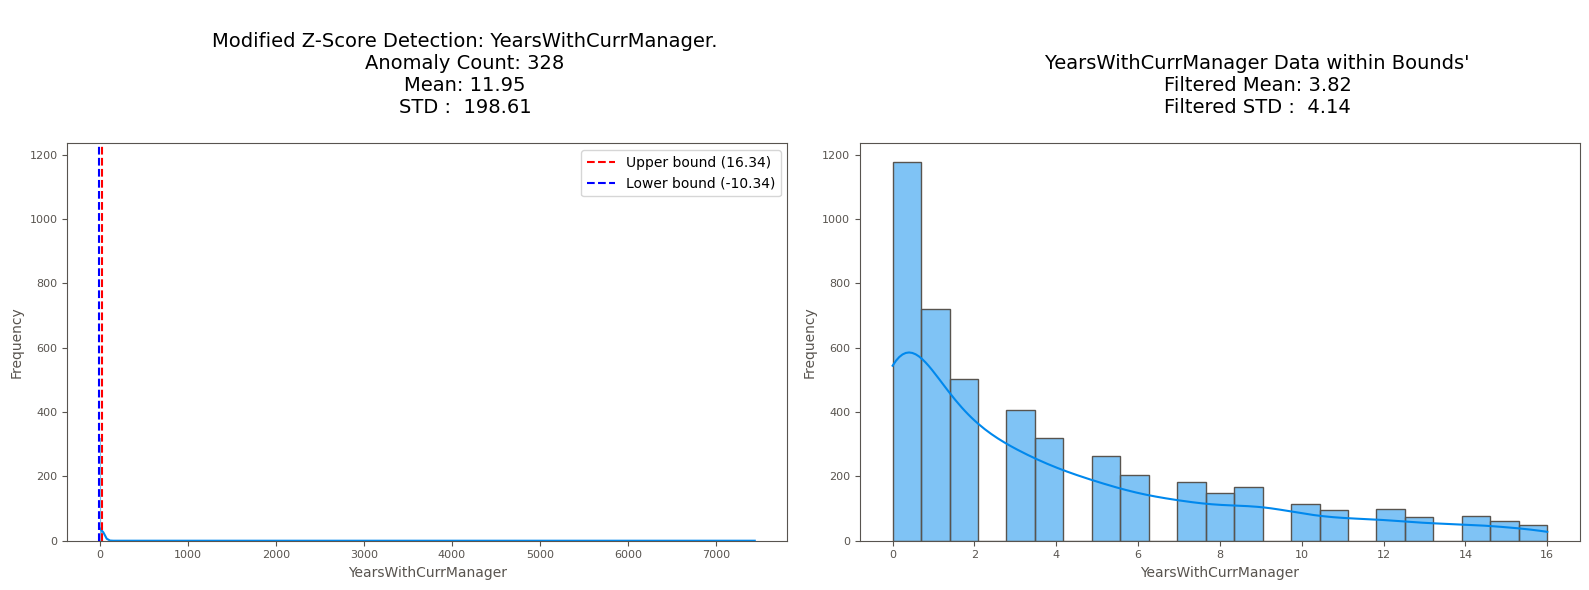

Column: YearsWithCurrManager



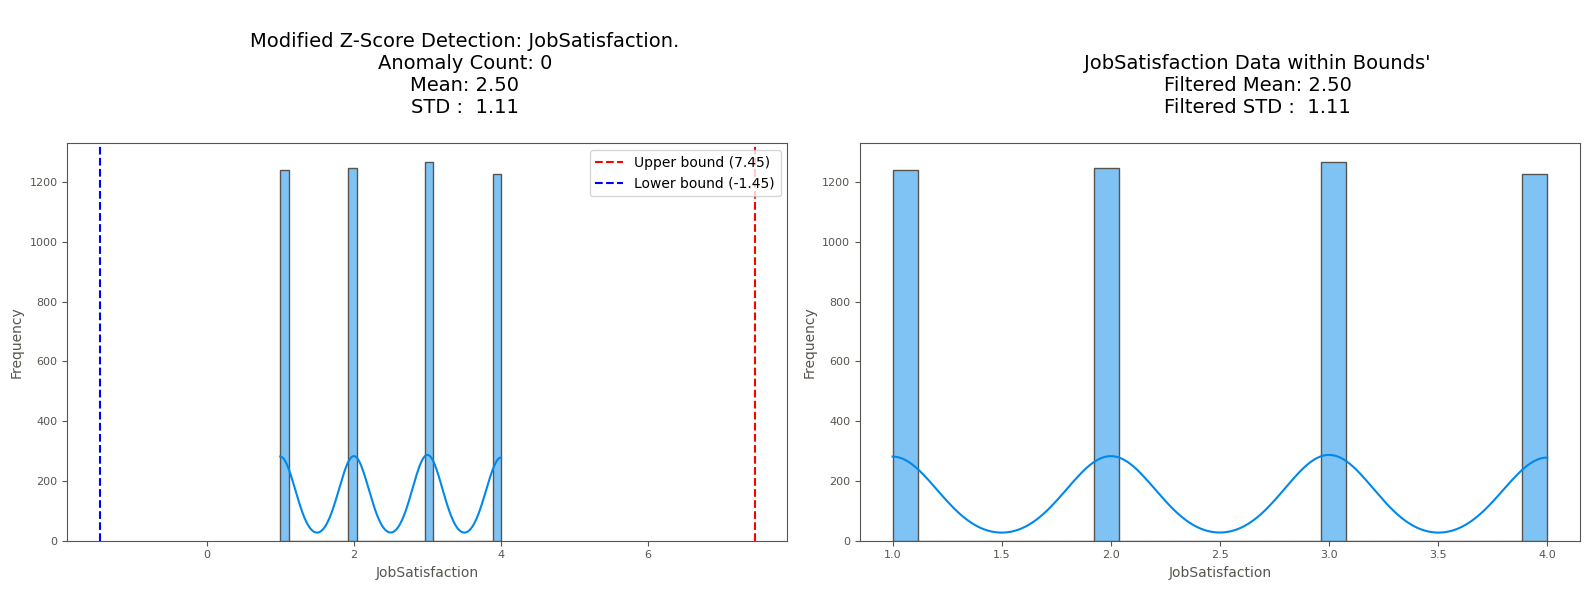

Column: JobSatisfaction



In [399]:
plot_zscore_anomalies = True
threshold = 3.0

for col in numeric_columns:
    modified_z_score_anomaly_detection_with_two_plots(
        df=df_no_nan,
        column=col, 
        threshold=threshold, 
        plot=plot_zscore_anomalies
    )
    
    if plot_zscore_anomalies:
        print(f"Column: {col}")        
        print()
        plt.show()

In [400]:
df_no_nan.columns

Index(['Age', 'Gender', 'Department', 'Education', 'MaritalStatus',
       'YearsAtCompany', 'JobRole', 'MonthlyIncome', 'OverTime',
       'BusinessTravel', 'DistanceFromHome', 'JobLevel', 'PercentSalaryHike',
       'PerformanceRating', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'JobSatisfaction', 'Attrition',
       'modified_z_score_Age', 'anomaly_Age',
       'modified_z_score_YearsAtCompany', 'anomaly_YearsAtCompany',
       'modified_z_score_MonthlyIncome', 'anomaly_MonthlyIncome',
       'modified_z_score_DistanceFromHome', 'anomaly_DistanceFromHome',
       'modified_z_score_JobLevel', 'anomaly_JobLevel',
       'modified_z_score_PercentSalaryHike', 'anomaly_PercentSalaryHike',
       'modified_z_score_PerformanceRating', 'anomaly_PerformanceRating',
       'modified_z_score_YearsInCurrentRole', 'anomaly_YearsInCurrentRole',
       'modified_z_score_YearsSinceLastPromotion',
       'anomaly_YearsSinceLastPromotion',
       'modified_z_score

In [401]:
anomaly_columns = [col for col in df_no_nan.columns if col.startswith("anomaly")]
anomaly_columns

['anomaly_Age',
 'anomaly_YearsAtCompany',
 'anomaly_MonthlyIncome',
 'anomaly_DistanceFromHome',
 'anomaly_JobLevel',
 'anomaly_PercentSalaryHike',
 'anomaly_PerformanceRating',
 'anomaly_YearsInCurrentRole',
 'anomaly_YearsSinceLastPromotion',
 'anomaly_YearsWithCurrManager',
 'anomaly_JobSatisfaction']

In [402]:
def filter_anomalies(df, anomaly_columns):
    """
    Filters a DataFrame to return only the rows where any value in the specified anomaly columns is True.
    
    :param df: The DataFrame containing the data.
    :param anomaly_columns: A list of column names that indicate anomalies (boolean columns).
    :return: Filtered DataFrame where any value in the specified anomaly columns is True.
    """
    # Use the any() function to filter rows where any of the anomaly columns are True
    filtered_df = df[~df[anomaly_columns].any(axis=1)]
    
    return filtered_df

In [403]:
df_no_nan.shape

(4982, 41)

In [404]:
df_no_anomalies = filter_anomalies(
    df=df_no_nan,
    anomaly_columns=anomaly_columns,
)


print(df_no_anomalies.shape)
df_no_anomalies.head()

(4416, 41)


,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,...,modified_z_score_PerformanceRating,anomaly_PerformanceRating,modified_z_score_YearsInCurrentRole,anomaly_YearsInCurrentRole,modified_z_score_YearsSinceLastPromotion,anomaly_YearsSinceLastPromotion,modified_z_score_YearsWithCurrManager,anomaly_YearsWithCurrManager,modified_z_score_JobSatisfaction,anomaly_JobSatisfaction
0,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,...,0.0000,False,-0.562083,False,-0.449667,False,-0.674500,False,-1.3490,False
1,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,...,-0.6745,False,0.786917,False,1.798667,False,0.899333,False,-1.3490,False
2,32.0,Male,HR,PhD,Single,35.0,Clerk,7357,No,Non-Travel,...,-0.6745,False,0.449667,False,0.899333,False,-0.674500,False,0.6745,False
3,60.0,Male,Support,PhD,Single,39.0,Technician,2327,Yes,Travel_Rarely,...,0.0000,False,0.562083,False,0.674500,False,0.449667,False,0.0000,False
4,25.0,Male,Support,High School,Single,14.0,Executive,12285,Yes,Travel_Rarely,...,0.6745,False,0.224833,False,0.224833,False,1.349000,False,0.0000,False


In [405]:
# Clean up Cols

z_score_col_names = [col for col in df_no_anomalies.columns if col.startswith("modified_z_score_")]
anomaly_column_names = [col for col in df_no_anomalies.columns if col.startswith("anomaly")]
cos_to_drop = z_score_col_names + anomaly_column_names


df_no_anomalies_cleaned = df_no_anomalies.drop(
    columns=cos_to_drop, 
    # errors="ignore"
)
print(f"Dropped all columns:\n", cos_to_drop)

Dropped all columns:
 ['modified_z_score_Age', 'modified_z_score_YearsAtCompany', 'modified_z_score_MonthlyIncome', 'modified_z_score_DistanceFromHome', 'modified_z_score_JobLevel', 'modified_z_score_PercentSalaryHike', 'modified_z_score_PerformanceRating', 'modified_z_score_YearsInCurrentRole', 'modified_z_score_YearsSinceLastPromotion', 'modified_z_score_YearsWithCurrManager', 'modified_z_score_JobSatisfaction', 'anomaly_Age', 'anomaly_YearsAtCompany', 'anomaly_MonthlyIncome', 'anomaly_DistanceFromHome', 'anomaly_JobLevel', 'anomaly_PercentSalaryHike', 'anomaly_PerformanceRating', 'anomaly_YearsInCurrentRole', 'anomaly_YearsSinceLastPromotion', 'anomaly_YearsWithCurrManager', 'anomaly_JobSatisfaction']


In [406]:
df_no_anomalies_cleaned.tail()

,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
4994,20.0,Male,HR,PhD,Divorced,35.0,Manager,19280,No,Travel_Frequently,34,5.0,19,2.0,1.0,1.0,1,3.0,No
4995,33.0,Female,HR,Masters,Married,6.0,Executive,8345,Yes,Travel_Frequently,23,1.0,14,3.0,1.0,0.0,1,2.0,No
4996,22.0,Male,Finance,Bachelors,Single,22.0,Technician,15322,No,Travel_Frequently,49,2.0,24,2.0,5.0,1.0,3,4.0,Yes
4998,27.0,Female,Finance,High School,Married,31.0,Technician,18398,Yes,Non-Travel,19,5.0,15,4.0,29.0,4.0,12,2.0,Yes
4999,36.0,Female,Development,High School,Married,20.0,Technician,13320,No,Non-Travel,37,4.0,6,2.0,17.0,16.0,0,3.0,No


In [407]:
mean_num_since_promotion = df_no_anomalies_cleaned["YearsAtCompany"].mean()
mean_num_since_promotion

np.float64(18.213541666666668)

In [408]:
df_no_anomalies_cleaned["YearsAtCompany"].describe()

count    4416.000000
mean       18.213542
std        11.206045
min         0.000000
25%         9.000000
50%        17.000000
75%        28.000000
max        39.000000
Name: YearsAtCompany, dtype: float64

In [409]:
mean_num_since_promotion = df_no_anomalies_cleaned["YearsWithCurrManager"].mean()
mean_num_since_promotion

np.float64(3.613451086956522)

In [410]:
mean_num_since_promotion = df_no_anomalies_cleaned["YearsInCurrentRole"].mean()
mean_num_since_promotion

np.float64(7.9513134057971016)

In [411]:
mean_num_since_promotion = df_no_anomalies_cleaned["YearsSinceLastPromotion"].mean()
mean_num_since_promotion

np.float64(3.5686141304347827)

## Note:

After Cleaning data - Looks about right.

In [412]:
def sanity_check(df, reference_column, columns_to_check):
    """
    Adds a boolean feature `sanity_feature_value_check` that indicates if any of the values in
    the specified columns are greater than the reference column.
    
    :param df: The DataFrame.
    :param reference_column: The column to use as the reference for the check.
    :param columns_to_check: A list of columns to compare against the reference column.
    :return: The DataFrame with the new sanity check feature.
    """
    # Initialize sanity_feature_value_check to True
    df['sanity_feature_value_check'] = True
    
    # Loop through the columns to check if any value is greater than the reference column
    for col in columns_to_check:
        df['sanity_feature_value_check'] &= df[col] <= df[reference_column]
    
    return df

In [413]:
df_no_anomalies_cleaned = sanity_check(df_no_anomalies_cleaned, 'YearsAtCompany', ["YearsInCurrentRole", "YearsWithCurrManager", "YearsSinceLastPromotion"])
df_no_anomalies_cleaned["sanity_feature_value_check"].value_counts()

sanity_feature_value_check
True     4413
False       3
Name: count, dtype: int64

In [414]:
df_no_anomalies_cleaned[df_no_anomalies_cleaned["sanity_feature_value_check"] == False][["YearsAtCompany", "YearsInCurrentRole", "YearsWithCurrManager", "YearsSinceLastPromotion"]]

,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,YearsSinceLastPromotion
49,6.0,6.0,5,8.0
1479,2.0,1.0,4,1.0
4161,14.0,17.0,15,14.0


In [416]:
df_no_anomalies_cleaned_sanity = df_no_anomalies_cleaned[df_no_anomalies_cleaned["sanity_feature_value_check"] == True]
df_no_anomalies_cleaned_sanity = df_no_anomalies_cleaned_sanity.drop(columns=["sanity_feature_value_check"])

print(df_no_anomalies_cleaned_sanity.shape)
df_no_anomalies_cleaned_sanity.tail(2)

(4413, 19)


,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
4998,27.0,Female,Finance,High School,Married,31.0,Technician,18398,Yes,Non-Travel,19,5.0,15,4.0,29.0,4.0,12,2.0,Yes
4999,36.0,Female,Development,High School,Married,20.0,Technician,13320,No,Non-Travel,37,4.0,6,2.0,17.0,16.0,0,3.0,No


## Notes:
- Issue here: we see there are 6 fields where the `YearsAtCompany` happens to be smaller than one of ["YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]


1x very good example is:
- A person who has been at the company for 6 years, and has been 6 years in their current role, has had 8 years since their last promotion. That is impossible
- (OLD) Age of person is 30 but they have worked 35 years at the company (make a joke here - would fit suitably within the latest demanding job craze :D)


Conclusion:
- Dropping these rows since the data is not making sense

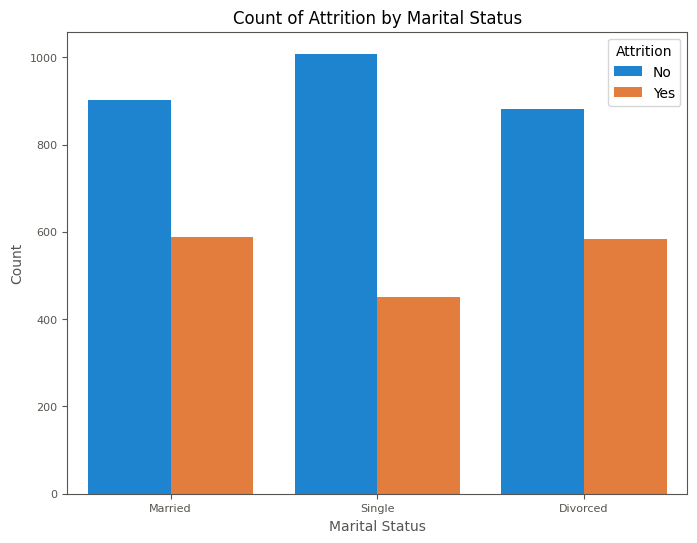

In [421]:
# Create a countplot to show the relationship between MaritalStatus and Attrition
plt.figure(figsize=(8, 6))
sns.countplot(x='MaritalStatus', hue='Attrition', data=df_no_anomalies_cleaned_sanity)
plt.title('Count of Attrition by Marital Status')
plt.ylabel('Count')
plt.xlabel('Marital Status')
plt.show()

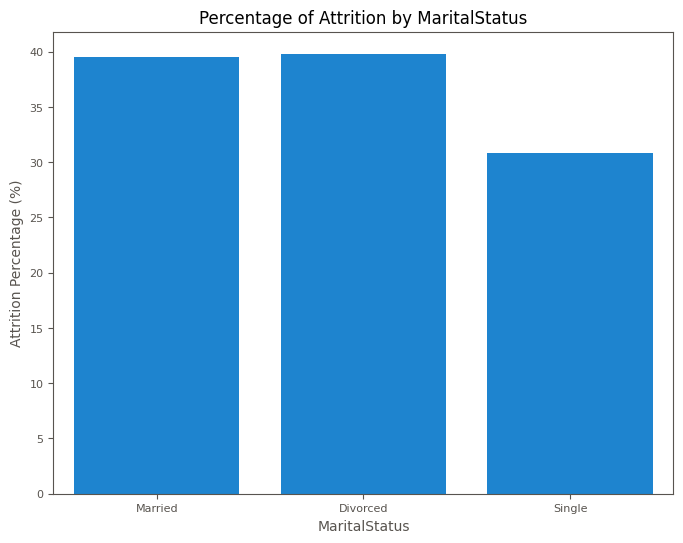

In [419]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_vs_target_percentage(df, feature, target):
    # Calculate the percentage of attrition for each category
    total_counts = df[feature].value_counts()
    attrition_counts = df[df[target] == 'Yes'][feature].value_counts()
    
    # Calculate percentage of attrition per category
    attrition_percentage = (attrition_counts / total_counts * 100).fillna(0)
    
    # Create a barplot to show attrition percentage
    plt.figure(figsize=(8, 6))
    sns.barplot(x=attrition_percentage.index, y=attrition_percentage.values)
    plt.title(f'Percentage of Attrition by {feature}')
    plt.ylabel('Attrition Percentage (%)')
    plt.xlabel(feature)
    plt.show()

# Plot percentage of Attrition for Marital Status
plot_categorical_vs_target_percentage(df_no_anomalies_cleaned_sanity, 'MaritalStatus', 'Attrition')


In [423]:
df_no_anomalies_cleaned_sanity

,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
0,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,9,4.0,24,2.0,2.0,1.0,0,1.0,No
1,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,39,1.0,20,1.0,14.0,11.0,7,1.0,No
2,32.0,Male,HR,PhD,Single,35.0,Clerk,7357,No,Non-Travel,1,1.0,12,1.0,11.0,7.0,0,4.0,Yes
3,60.0,Male,Support,PhD,Single,39.0,Technician,2327,Yes,Travel_Rarely,33,1.0,0,2.0,12.0,6.0,5,3.0,Yes
4,25.0,Male,Support,High School,Single,14.0,Executive,12285,Yes,Travel_Rarely,38,5.0,24,3.0,9.0,4.0,9,3.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,20.0,Male,HR,PhD,Divorced,35.0,Manager,19280,No,Travel_Frequently,34,5.0,19,2.0,1.0,1.0,1,3.0,No
4995,33.0,Female,HR,Masters,Married,6.0,Executive,8345,Yes,Travel_Frequently,23,1.0,14,3.0,1.0,0.0,1,2.0,No
4996,22.0,Male,Finance,Bachelors,Single,22.0,Technician,15322,No,Travel_Frequently,49,2.0,24,2.0,5.0,1.0,3,4.0,Yes
4998,27.0,Female,Finance,High School,Married,31.0,Technician,18398,Yes,Non-Travel,19,5.0,15,4.0,29.0,4.0,12,2.0,Yes


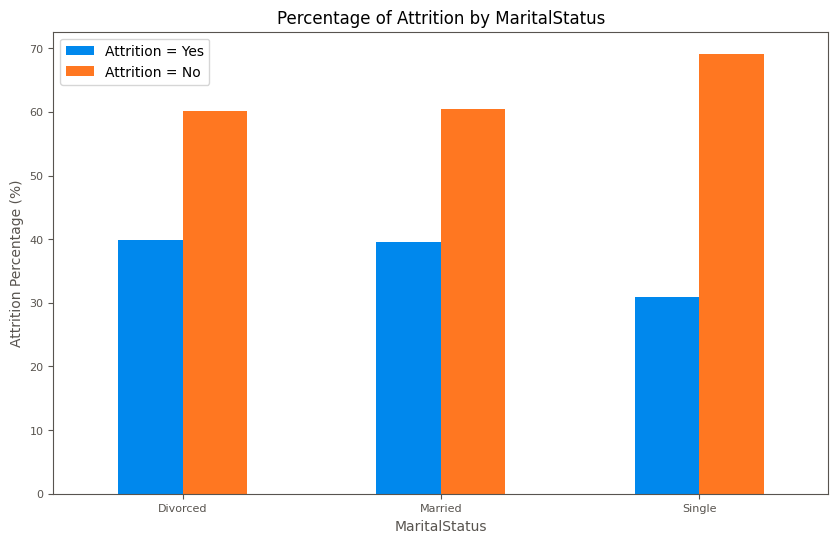

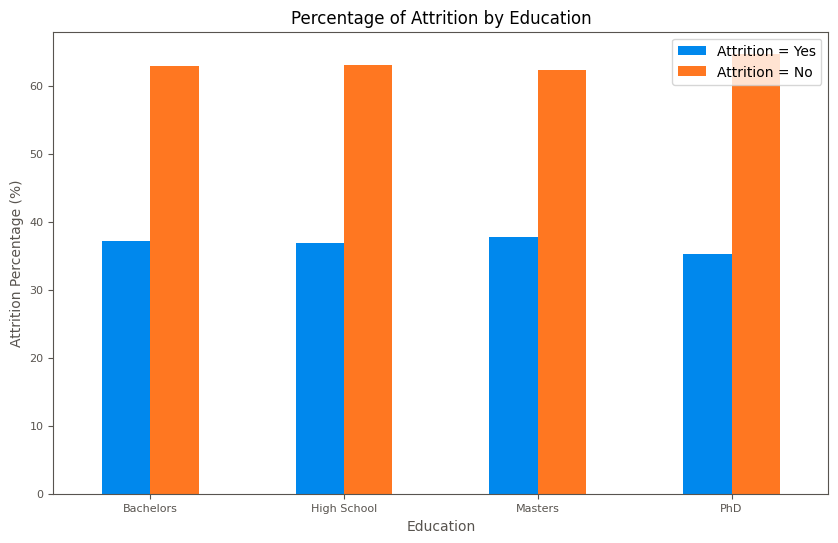

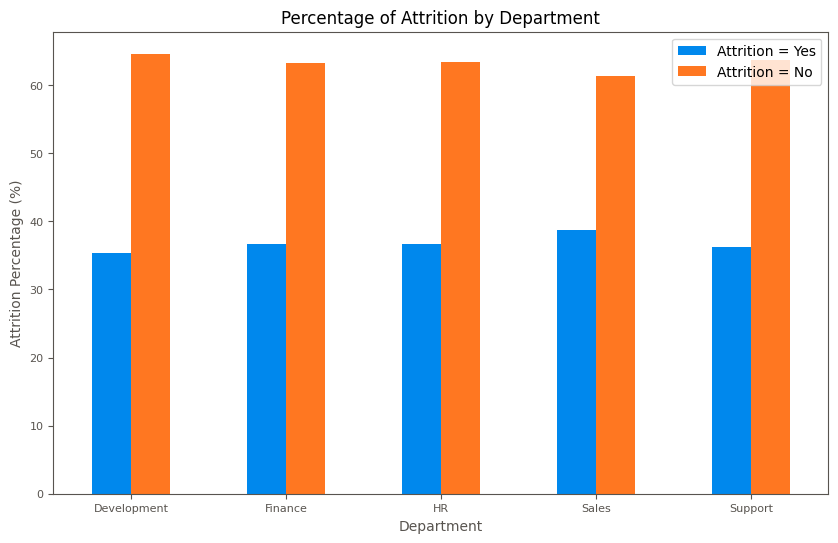

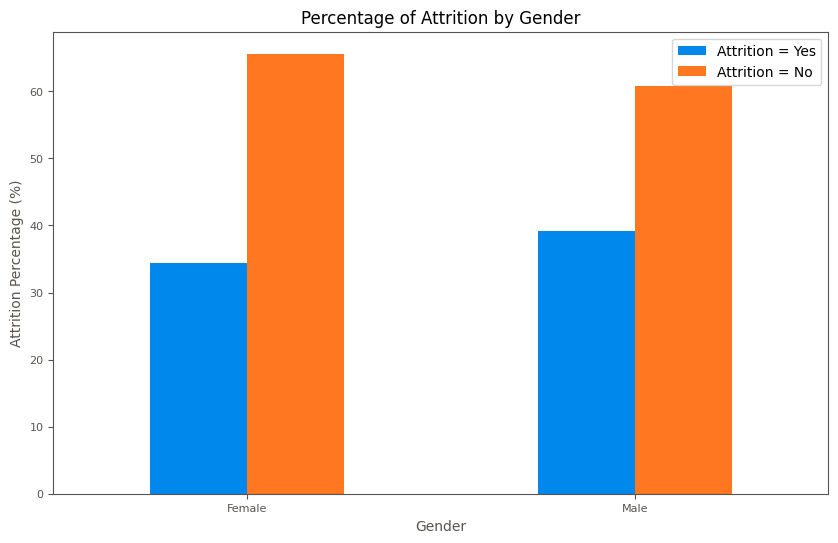

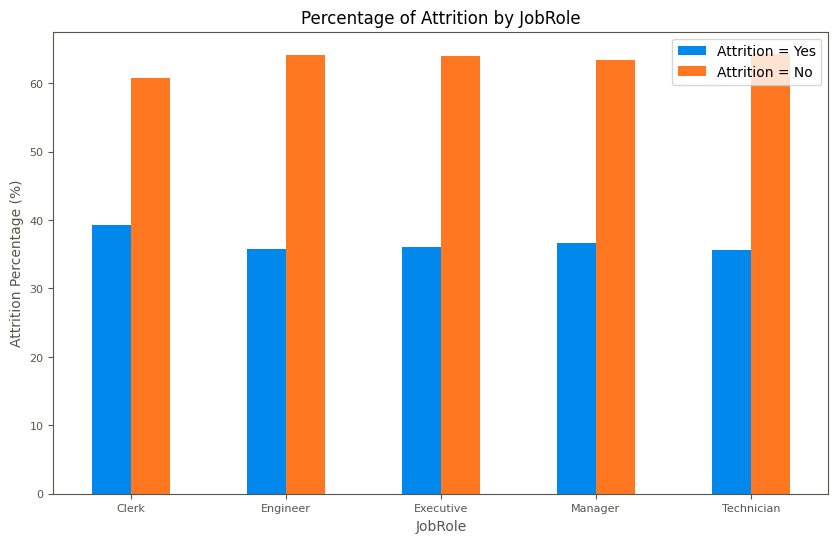

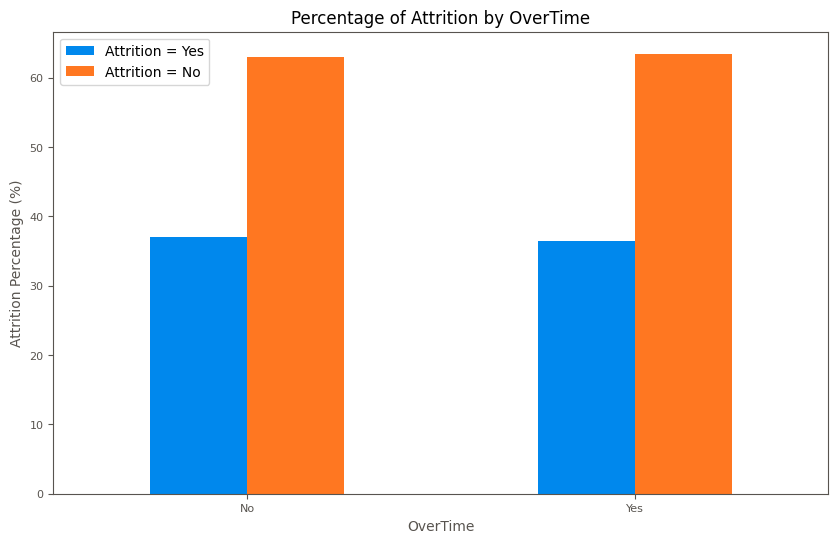

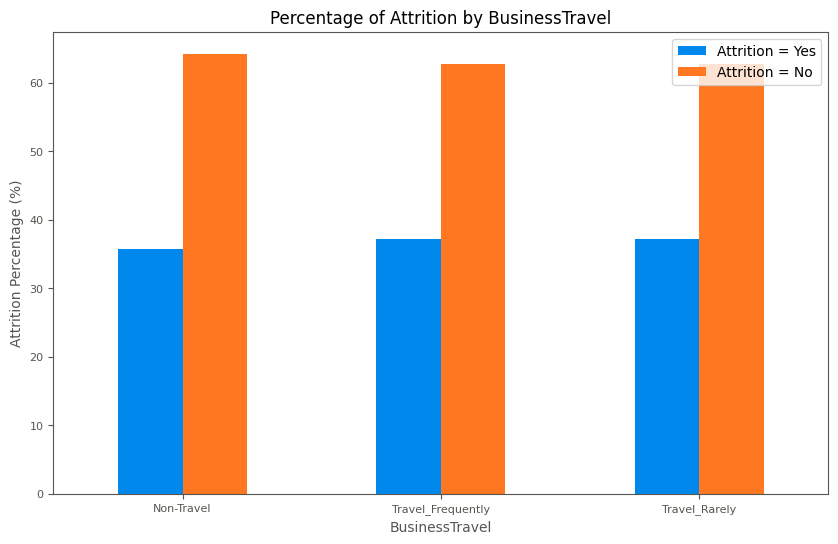

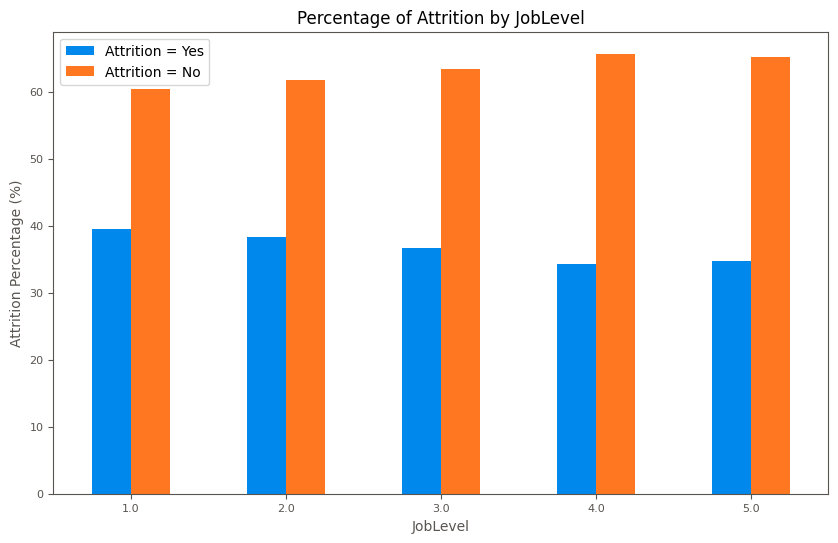

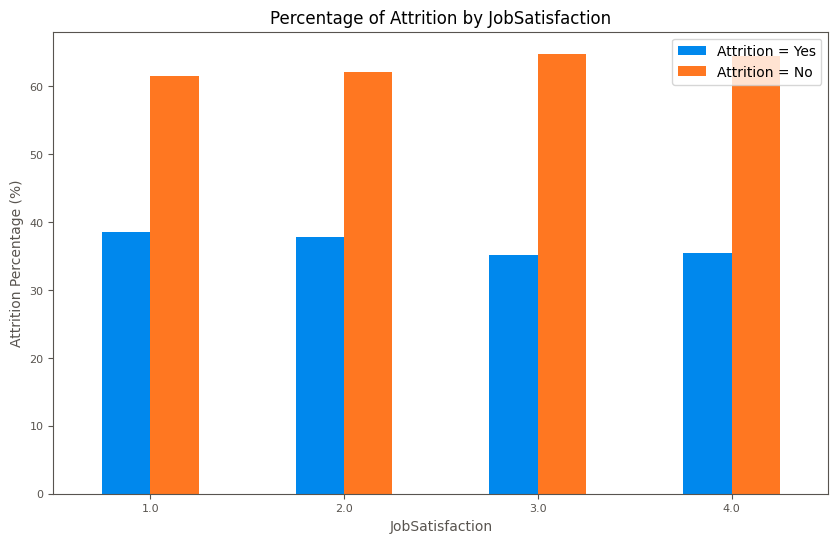

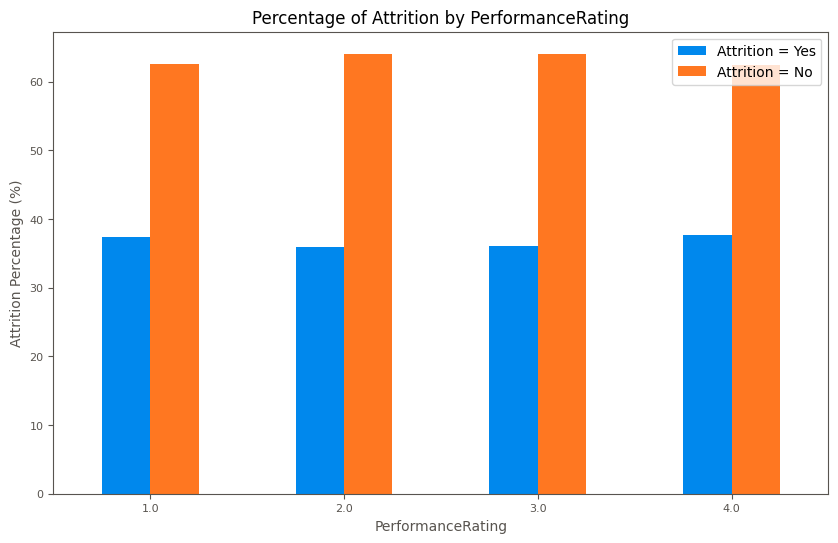

In [426]:
def plot_categorical_vs_target_grouped(df, feature, target):
    total_counts = df[feature].value_counts()
    attrition_yes_counts = df[df[target] == 'Yes'][feature].value_counts()
    attrition_no_counts = df[df[target] == 'No'][feature].value_counts()
    attrition_yes_percentage = (attrition_yes_counts / total_counts * 100).fillna(0)
    attrition_no_percentage = (attrition_no_counts / total_counts * 100).fillna(0)
    
    # Create a DataFrame for easier plotting
    percentages_df = pd.DataFrame({
        'Attrition = Yes': attrition_yes_percentage,
        'Attrition = No': attrition_no_percentage
    })
    
    # Plot side-by-side bars
    percentages_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Percentage of Attrition by {feature}')
    plt.ylabel('Attrition Percentage (%)')
    plt.xlabel(feature)
    plt.xticks(rotation=0)
    plt.show()


# List of categorical features
categorical_features = [
    'MaritalStatus', 'Education', 'Department', 'Gender', 'JobRole', 'OverTime', 
    'BusinessTravel', 'JobLevel', 'JobSatisfaction', 'PerformanceRating'
]

# Assuming df is your DataFrame and 'Attrition' is the target variable
for feature in categorical_features:
    plot_categorical_vs_target_grouped(
        df_no_anomalies_cleaned_sanity,
        feature=feature, 
        target='Attrition'
    )

## Feature Engineering

In [417]:
df_no_anomalies_cleaned_sanity.head(2)

,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition
0,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,9,4.0,24,2.0,2.0,1.0,0,1.0,No
1,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,39,1.0,20,1.0,14.0,11.0,7,1.0,No


In [355]:
df_no_anomalies_cleaned_sanity[df_no_anomalies_cleaned_sanity["YearsAtCompany"] == df_no_anomalies_cleaned_sanity["YearsInCurrentRole"]]["YearsSinceLastPromotion"].describe()

count    486.000000
mean       2.864198
std        4.277738
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       18.000000
Name: YearsSinceLastPromotion, dtype: float64

In [356]:
df_no_anomalies_cleaned_sanity["JobSatisfaction"].value_counts()

JobSatisfaction
3         1163
1         1139
2         1139
4         1125
"2.00"       5
"3.00"       4
Name: count, dtype: int64

In [346]:
df_no_anomalies_cleaned_sanity.head()

,Age,Gender,Department,Education,MaritalStatus,YearsAtCompany,JobRole,MonthlyIncome,OverTime,BusinessTravel,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction,Attrition,target
0,56.0,Male,Support,Masters,Married,9.0,Technician,19844,No,Travel_Frequently,9,4,24,2,2.0,1.0,0,1,No,0
1,46.0,Female,Sales,Bachelors,Single,29.0,Engineer,6687,No,Non-Travel,39,1,20,1,14.0,11.0,7,1,No,0
2,32.0,Male,HR,PhD,Single,35.0,Clerk,7357,No,Non-Travel,1,1,12,1,11.0,7.0,0,4,Yes,1
3,60.0,Male,Support,PhD,Single,39.0,Technician,2327,Yes,Travel_Rarely,33,1,0,2,12.0,6.0,5,"""3.00""",Yes,1
4,25.0,Male,Support,High School,Single,14.0,Executive,12285,Yes,Travel_Rarely,38,5,24,3,9.0,4.0,9,3,Yes,1


In [347]:
target_class_mapper = {
    "No": 0,
    "Yes": 1,
}
target_class = "Attrition"
df_no_anomalies_cleaned_sanity["target"] = df_no_anomalies_cleaned_sanity[target_class].apply(lambda x: target_class_mapper[x])
df_no_anomalies_cleaned_sanity["target"].value_counts()

target
0    2882
1    1693
Name: count, dtype: int64

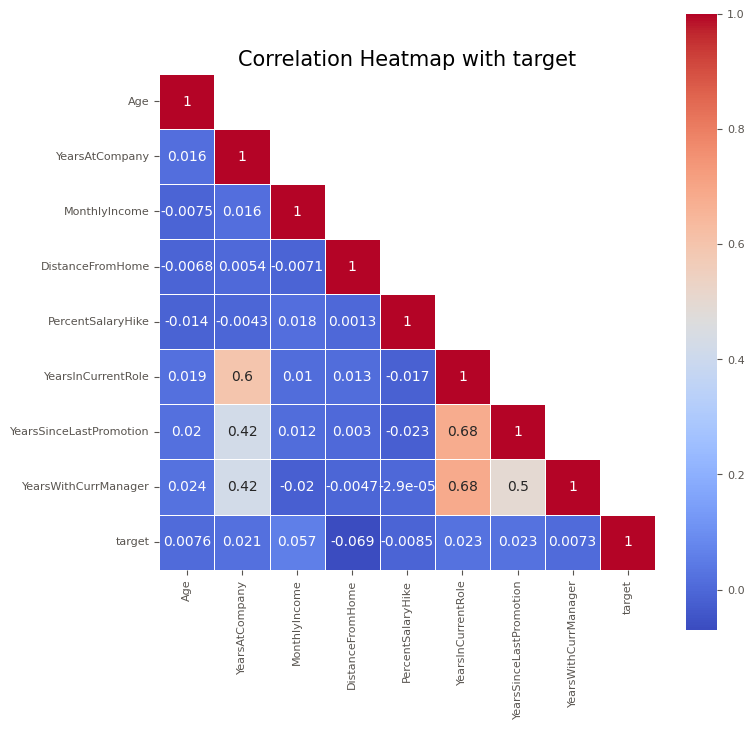

In [348]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

    
def plot_correlation_matrix_with_target(df, target_column, figsize=(8, 8)):
    """
    Plots a correlation heatmap for all features including the target variable.
    A diagonal heatmap will be shown, where the correlation between each feature and the target variable is highlighted.
    
    :param df: The DataFrame containing the features and the target column.
    :param target_column: The name of the target variable (e.g., 'Attrition').
    :param figsize: Size of the figure for plotting.
    """
    # Select only numeric columns for the correlation matrix
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Calculate the correlation matrix for the numeric features
    corr_matrix = df[numeric_columns].corr()
    
    # Plot the heatmap with a diagonal line
    plt.figure(figsize=figsize)
    
    # Generate a mask for the upper triangle (keeping the diagonal)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap='coolwarm', 
        cbar=True, square=True, 
        linewidths=0.5, linecolor='white', 
        mask=mask
    )
    
    # Highlight the diagonal
    plt.title(f'Correlation Heatmap with {target_column}', fontsize=15)
    plt.show()


# Plot heatmaps showing correlation between each feature and Attrition
plot_correlation_matrix_with_target(
    df=df_no_anomalies_cleaned_sanity.drop(columns="Attrition"), 
    target_column='target',
)

## 3. Encoding Categorical Variables

In [148]:
object_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()
object_columns


['Gender',
 'Department',
 'Education',
 'MaritalStatus',
 'JobRole',
 'OverTime',
 'BusinessTravel',
 'JobLevel',
 'PerformanceRating',
 'JobSatisfaction',
 'Attrition']

In [154]:
# pd.api.types.is_object_dtype(df_cleaned["JobSatisfaction"])

categorical_columns = [column for column in df_cleaned.columns if pd.api.types.is_object_dtype(df_cleaned[column])]
categorical_columns

['Gender',
 'Department',
 'Education',
 'MaritalStatus',
 'JobRole',
 'OverTime',
 'BusinessTravel',
 'Attrition']

In [155]:
df_transformed = df_cleaned.copy()
df_transformed.shape

(4982, 19)

In [129]:

# Label encode Attrition
# df_transformed['Attrition'] = OneHotEncoder().fit_transform(df_transformed['Attrition'])
# # One-hot encode other categorical features
# df_transformed = pd.get_dummies(df_transformed, columns=categorical_columns)


# print(df_transformed.shape)
# df_transformed.head()

In [156]:

def one_hot_encode_selected_columns(df, columns_to_encode):
    """
    One-hot encodes the specified object columns and saves the mappings of original columns to the new one-hot encoded columns.
    Returns the transformed dataframe and a dictionary of mappings.
    """
    one_hot_mappings = {}
    
    # Iterate through the specified columns
    for column in columns_to_encode:
        # Check if the column exists in the dataframe and is of type object
        if column in df.columns and pd.api.types.is_object_dtype(df[column]):
            # Perform one-hot encoding on the column
            dummies = pd.get_dummies(df[column], prefix=column)
            # Save the mapping of original column to one-hot encoded columns
            one_hot_mappings[column] = dummies.columns.tolist()
            # Drop the original column and concatenate the one-hot encoded columns
            df = df.drop(column, axis=1)
            df = pd.concat([df, dummies], axis=1)
    
    return df, one_hot_mappings


In [157]:
df_one_hot, one_hot_mappings = one_hot_encode_selected_columns(df=df_transformed, columns_to_encode=categorical_columns)

print(df_one_hot.shape)
df_one_hot.head()

(4982, 37)


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,...,JobRole_Executive,JobRole_Manager,JobRole_Technician,OverTime_No,OverTime_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Attrition_No,Attrition_Yes
0,56.0,9.0,19844,9,4.0,24,2.0,2.0,1.0,0,...,False,False,True,True,False,False,True,False,True,False
1,46.0,29.0,6687,39,1.0,20,1.0,14.0,11.0,7,...,False,False,False,True,False,True,False,False,True,False
2,32.0,35.0,7357,1,1.0,12,1.0,11.0,7.0,0,...,False,False,False,True,False,True,False,False,False,True
3,60.0,39.0,2327,33,1.0,0,2.0,12.0,6.0,5,...,False,False,True,False,True,False,False,True,False,True
4,25.0,14.0,12285,38,5.0,24,3.0,9.0,4.0,9,...,True,False,False,False,True,False,False,True,False,True


In [158]:
one_hot_mappings

{'Gender': ['Gender_Female', 'Gender_Male'],
 'Department': ['Department_Development',
  'Department_Finance',
  'Department_HR',
  'Department_Sales',
  'Department_Support'],
 'Education': ['Education_Bachelors',
  'Education_High School',
  'Education_Masters',
  'Education_PhD'],
 'MaritalStatus': ['MaritalStatus_Divorced',
  'MaritalStatus_Married',
  'MaritalStatus_Single'],
 'JobRole': ['JobRole_Clerk',
  'JobRole_Engineer',
  'JobRole_Executive',
  'JobRole_Manager',
  'JobRole_Technician'],
 'OverTime': ['OverTime_No', 'OverTime_Yes'],
 'BusinessTravel': ['BusinessTravel_Non-Travel',
  'BusinessTravel_Travel_Frequently',
  'BusinessTravel_Travel_Rarely'],
 'Attrition': ['Attrition_No', 'Attrition_Yes']}

In [159]:
integer_columns = df_one_hot.select_dtypes(include=['int', 'float']).columns.tolist()
integer_columns

['Age',
 'YearsAtCompany',
 'MonthlyIncome',
 'DistanceFromHome',
 'JobLevel',
 'PercentSalaryHike',
 'PerformanceRating',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'JobSatisfaction']

In [160]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_scaled = df_one_hot.copy()

df_scaled[integer_columns] = scaler.fit_transform(df_scaled[integer_columns])
df_scaled[integer_columns].head(2)


,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction
0,1.079193,-0.066973,0.316794,-1.133650,0.716959,0.006318,-0.434429,-0.065482,-0.055774,-0.060169,-1.344464
1,0.347840,-0.016940,-0.187038,0.995015,-1.397003,-0.006328,-1.323635,-0.023716,-0.006556,-0.024921,-1.344464


In [161]:
df_one_hot[integer_columns].describe()

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction
count,4982.000000,4982.000000,4.982000e+03,4982.000000,4982.000000,4982.000000,4982.000000,4982.000000,4982.000000,4982.000000,4982.000000
mean,41.243878,35.771578,1.157127e+04,24.976917,2.982537,22.001606,2.488559,20.813930,12.331995,11.949016,2.497591
std,13.674660,399.776555,2.611649e+04,14.094757,1.419278,316.344068,1.124712,287.345241,203.198549,198.612041,1.114006
min,4.000000,0.000000,2.000000e+03,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,30.000000,10.000000,6.638750e+03,13.000000,2.000000,6.000000,1.000000,3.000000,1.000000,1.000000,2.000000
50%,41.000000,20.000000,1.112150e+04,25.000000,3.000000,12.000000,2.000000,7.000000,3.000000,3.000000,3.000000
75%,53.000000,30.000000,1.557025e+04,37.000000,4.000000,18.000000,4.000000,15.000000,7.000000,7.000000,3.000000
max,99.000000,9999.000000,1.532624e+06,49.000000,5.000000,9999.000000,4.000000,9590.000000,7359.000000,7444.000000,4.000000


In [162]:
df_scaled[integer_columns].describe()

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSatisfaction
count,4.982000e+03,4.982000e+03,4.982000e+03,4.982000e+03,4.982000e+03,4.982000e+03,4.982000e+03,4.982000e+03,4.982000e+03,4.982000e+03,4.982000e+03
mean,-2.438836e-16,8.557319e-18,2.103674e-17,1.265770e-16,5.704879e-18,-2.139330e-18,-6.275367e-17,-1.140976e-17,1.140976e-17,2.852440e-18,-8.771252e-17
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-2.723842e+00,-8.948791e-02,-3.665207e-01,-1.701294e+00,-1.397003e+00,-6.955659e-02,-1.323635e+00,-7.244254e-02,-6.069548e-02,-6.016864e-02,-1.344464e+00
25%,-8.223244e-01,-6.447143e-02,-1.888852e-01,-8.498280e-01,-6.923489e-01,-5.058799e-02,-1.323635e+00,-6.200109e-02,-5.577369e-02,-5.513319e-02,-4.467132e-01
50%,-1.783609e-02,-3.945494e-02,-1.722351e-02,1.637873e-03,1.230528e-02,-3.161940e-02,-4.344294e-01,-4.807916e-02,-4.593011e-02,-4.506230e-02,4.510379e-01
75%,8.597875e-01,-1.443846e-02,1.531362e-01,8.531037e-01,7.169595e-01,-1.265081e-02,1.343983e+00,-2.023529e-02,-2.624296e-02,-2.492051e-02,4.510379e-01
max,4.224011e+00,2.492449e+01,5.824694e+01,1.704570e+00,1.421614e+00,3.154161e+01,1.343983e+00,3.330539e+01,3.615875e+01,3.742370e+01,1.348789e+00
